In [1]:
import polars as pl
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from itertools import groupby
from more_itertools import unzip

from data_split import StratifiedGroupKFold_custom

from jump_portrait.fetch import get_jump_image
from jump_portrait.utils import batch_processing, parallel

from collections.abc import Callable, Iterable
from typing import List

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import lightning as L


%load_ext autoreload
%autoreload 2
from parallel_training import run_train
import conv_model
import custom_dataset
from lightning_parallel_training import LightningModel
from lightning.pytorch import Trainer, seed_everything


# 1) Loading images and create a pytorch dataset

## a) Load Images using Jump_portrait

In [2]:
metadata_pre = pl.read_csv("target2_eq_moa2_metadata")

In [3]:
#site: 1-9 str
#channel: ER, AGP, Mito, DNA and RNA

Few remarks on Jump_portrait

* In get_jump_image
    - Would be better if instead of broadcasting the error: "More than one site found", a suggestion of correction was given
    - Would be great to enable to pass a list of str instead of just a str. 

* all the parameters of get_jump_image are not ully explained:
    - example ```apply_correction``` vs ```apply_illum```
    - ```compressed```
    - ```staging```
* tqdm takes a lot of space: let's try something from [here](https://stackoverflow.com/questions/41707229/why-is-tqdm-printing-to-a-newline-instead-of-updating-the-same-line), or add a way to disable it.

* Workflow 1 and workflow 2
    - parameter ```corrections``` is not consistently defined which I think is confusing:
      1. corrections = ["Orig"]  # Can also be "Illum"
      2. correction = None # or "Illum"
      

### i) function to overcome error occuring for some instance when calling get_jump_image_iter

In [4]:
def try_function(f: Callable):
    '''
    Wrap a function into an instance which will Try to call the function:
        If it success, return a tuple of function parameters + its results
        If it fails, return the function parameters
    '''
    # This assume parameters are packed in a tuple
    def batched_fn(*item, **kwargs):
        try:
            result = (*item, f(*item, **kwargs))
            
        except:
            result = item

        return result    
    return batched_fn

### ii) function to overcome turn get_jump_image_iter compatible with list and load data in a threaded fashion

In [5]:
def get_jump_image_iter(metadata: pl.DataFrame, channel: List[str], 
                        site:List[str], correction:str=None) -> (pl.DataFrame, List[tuple]): 
    '''
       Load jump image associated to metadata in a threaded fashion.
        ----------
    Parameters: 
        metadata(pl.DataFrame): must have the shape (Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well")
        channel(List[str]): list of channel desired
            Must be in ['DNA', 'ER', 'AGP', 'Mito', 'RNA']
        site(List[str]): list of site desired
            For compound, must be in ['1' - '6']
            For ORF, CRISPR, must be in ['1' - '9']
        correction(str): Must be 'Illum' or None
        ----------
    Return:
        features(pl.DataFrame): DataFrame collecting the metadata, channel, site, correction + the image
        work_fail(List(tuple): List collecting tuple of metadata which failed to load an image
        
    '''
    iterable = [(*metadata.row(i), ch, s, correction)
               for i in range(metadata.shape[0]) for s in site for ch in channel]
    img_list = parallel(iterable, batch_processing(try_function(get_jump_image)))
    
    img_list = sorted(img_list, key=lambda x: len(x))
    fail_success = {k: list(g) for k, g in groupby(img_list, key=lambda x: len(x))}
    if len(fail_success) == 1:
        img_success = list(fail_success.values())[0]
        work_fail = []
    else: 
        work_fail, img_success = fail_success.values()
    features = pl.DataFrame(img_success, 
                               schema=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well",
                                        "channel", "site", "correction",
                                        "img"])
    return features, work_fail

In [6]:
features_pre, work_fail = get_jump_image_iter(metadata_pre.select(pl.col(["Metadata_Source", "Metadata_Batch", 
                                                                               "Metadata_Plate", "Metadata_Well"])),
                                                        channel=['DNA'],#, 'ER', 'AGP', 'Mito', 'RNA'],
                                                        site=[str(i) for i in range(1, 7)],
                                                        correction=None) #None, 'Illum'

### iii) Add 'site' 'channel' and filter out sample which could not be load (using join)

In [7]:
metadata = metadata_pre.join(features_pre.select(pl.all().exclude(["correction", "img"])),
              on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
              how="inner").sort(by=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "site"])

metadata = metadata.with_columns(pl.arange(0,len(metadata)).alias("ID"))
features = features_pre.join(metadata.select(pl.col(["Metadata_Source", "Metadata_Batch", 
                                                 "Metadata_Plate", "Metadata_Well", "site", "ID"])),
                         on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", 
                             "Metadata_Well", "site"],
                         how="inner").sort(by="ID")

## b) Visualisation of some images

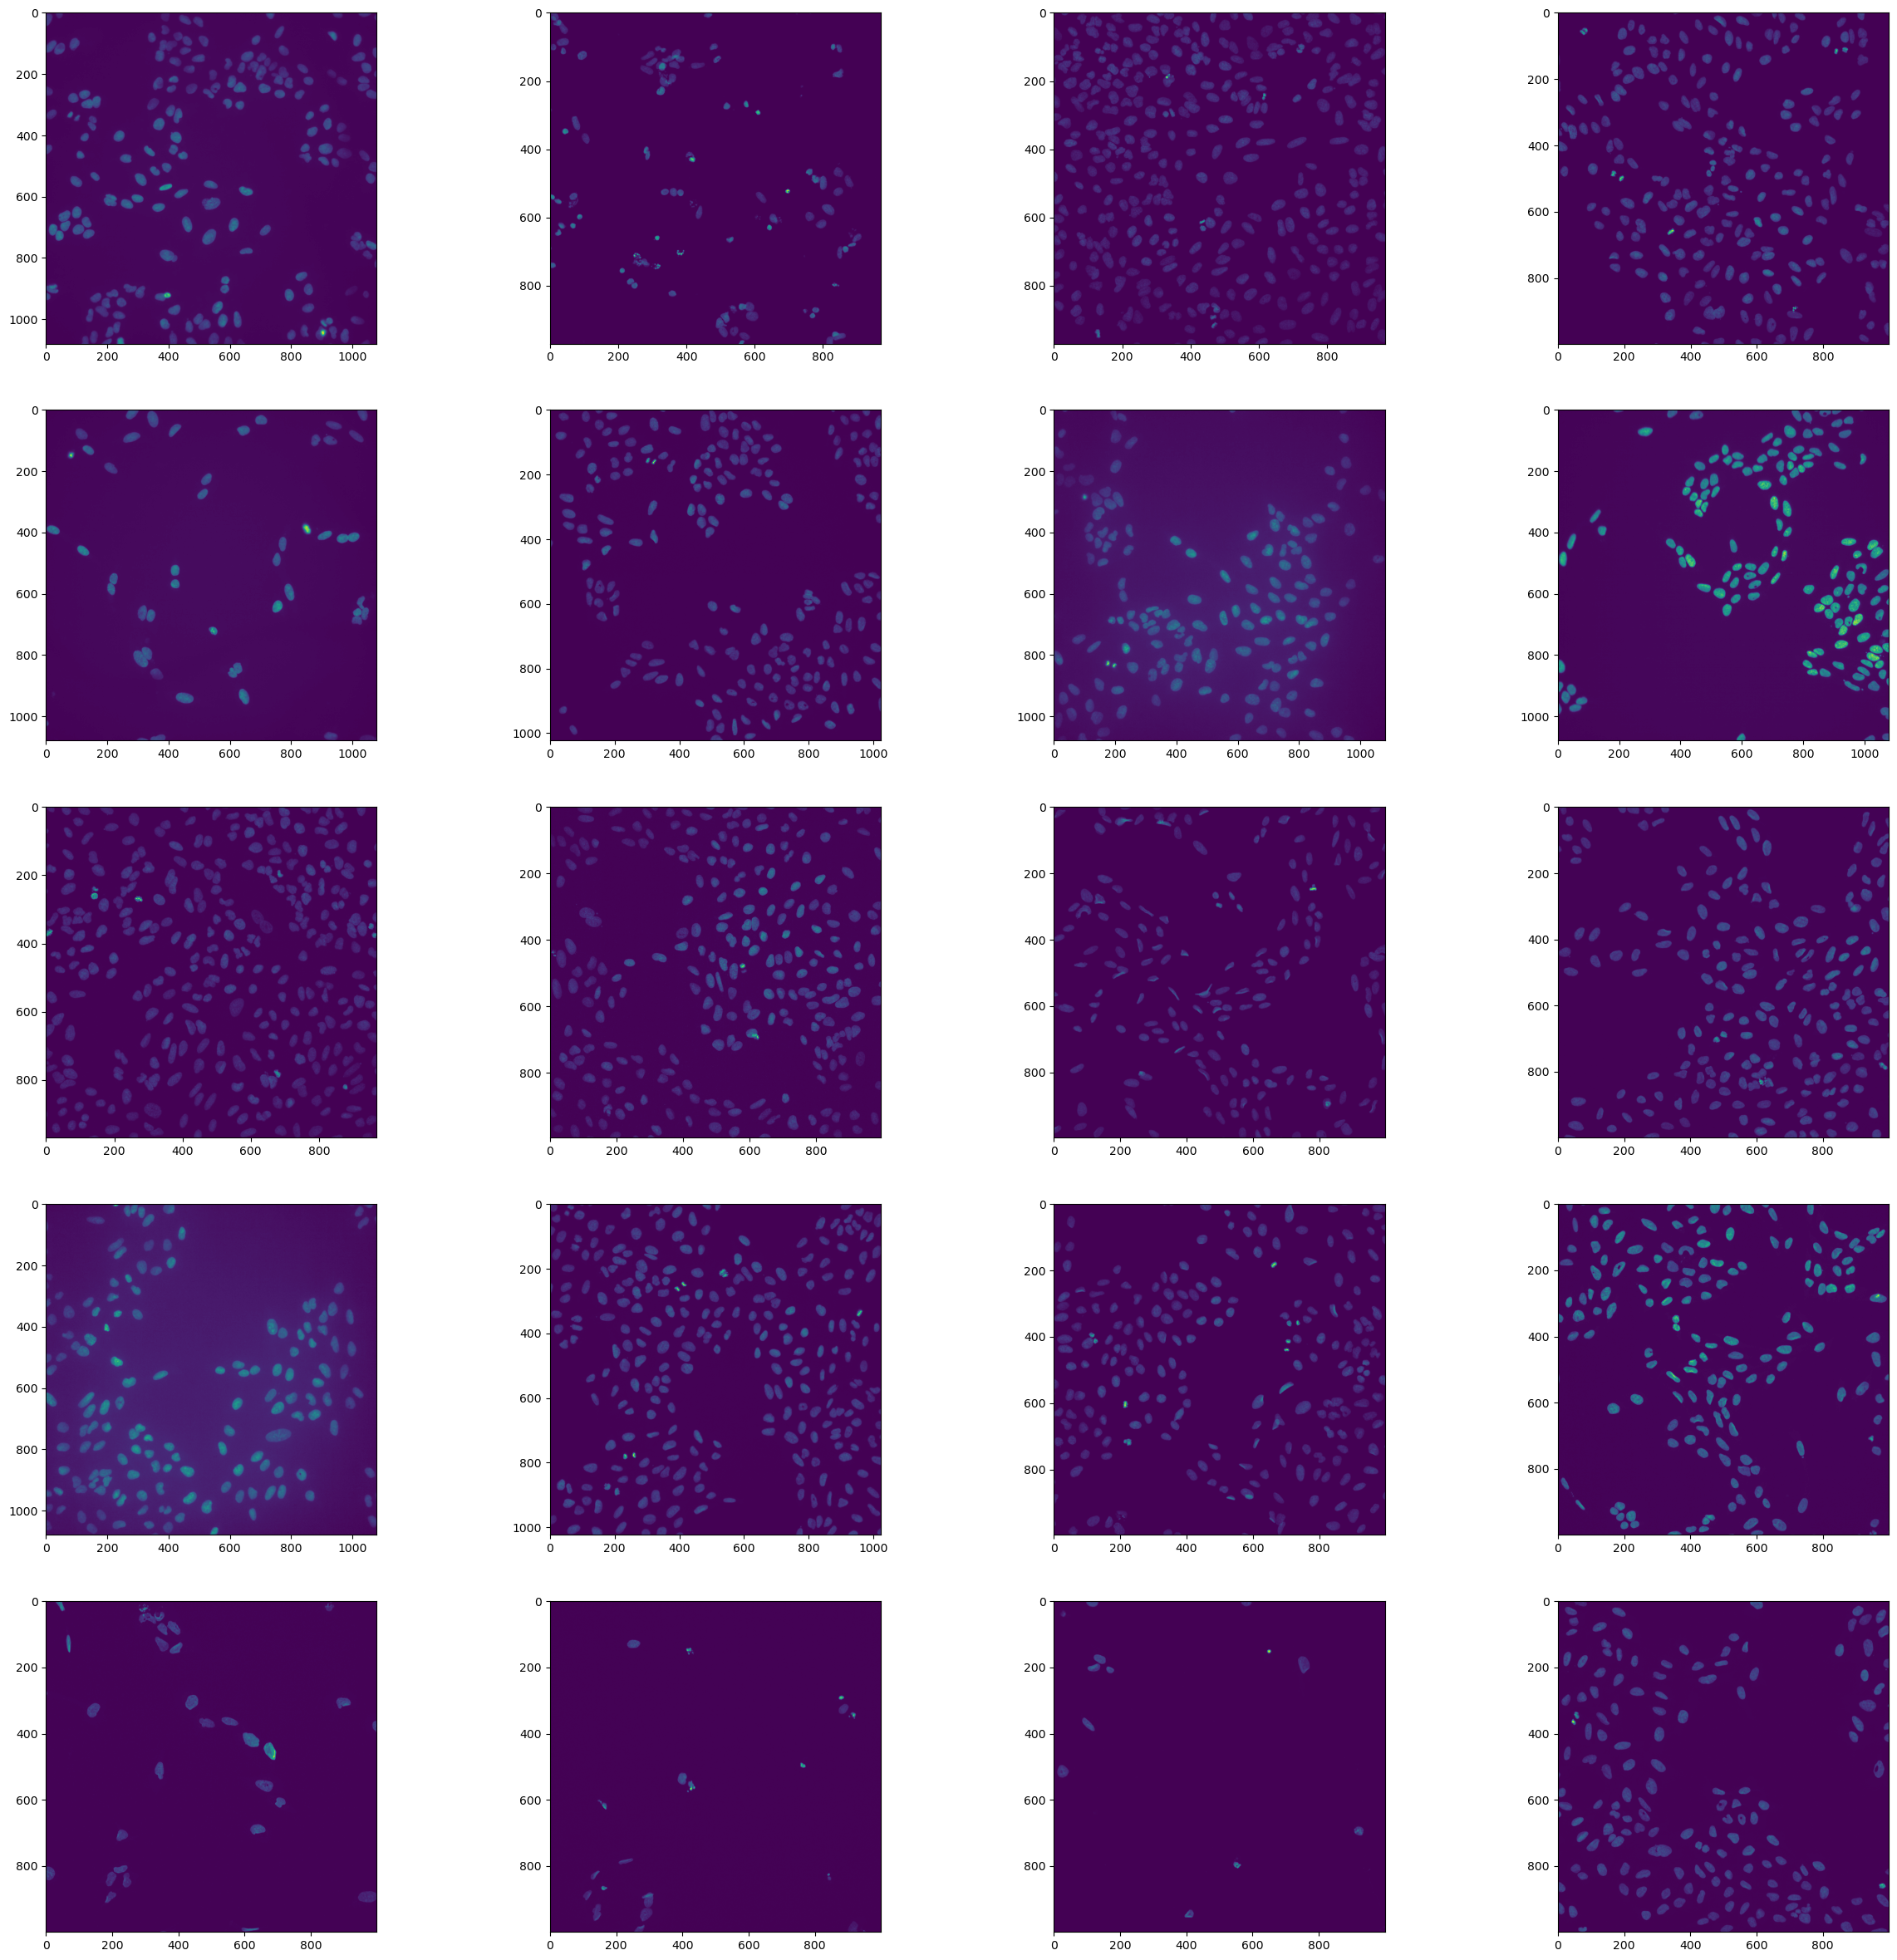

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(30,30))
axes = axes.flatten()
select = np.random.randint(0, len(features), (20))
for i in range(20):
    axes[i].imshow(features["img"][int(select[i])])

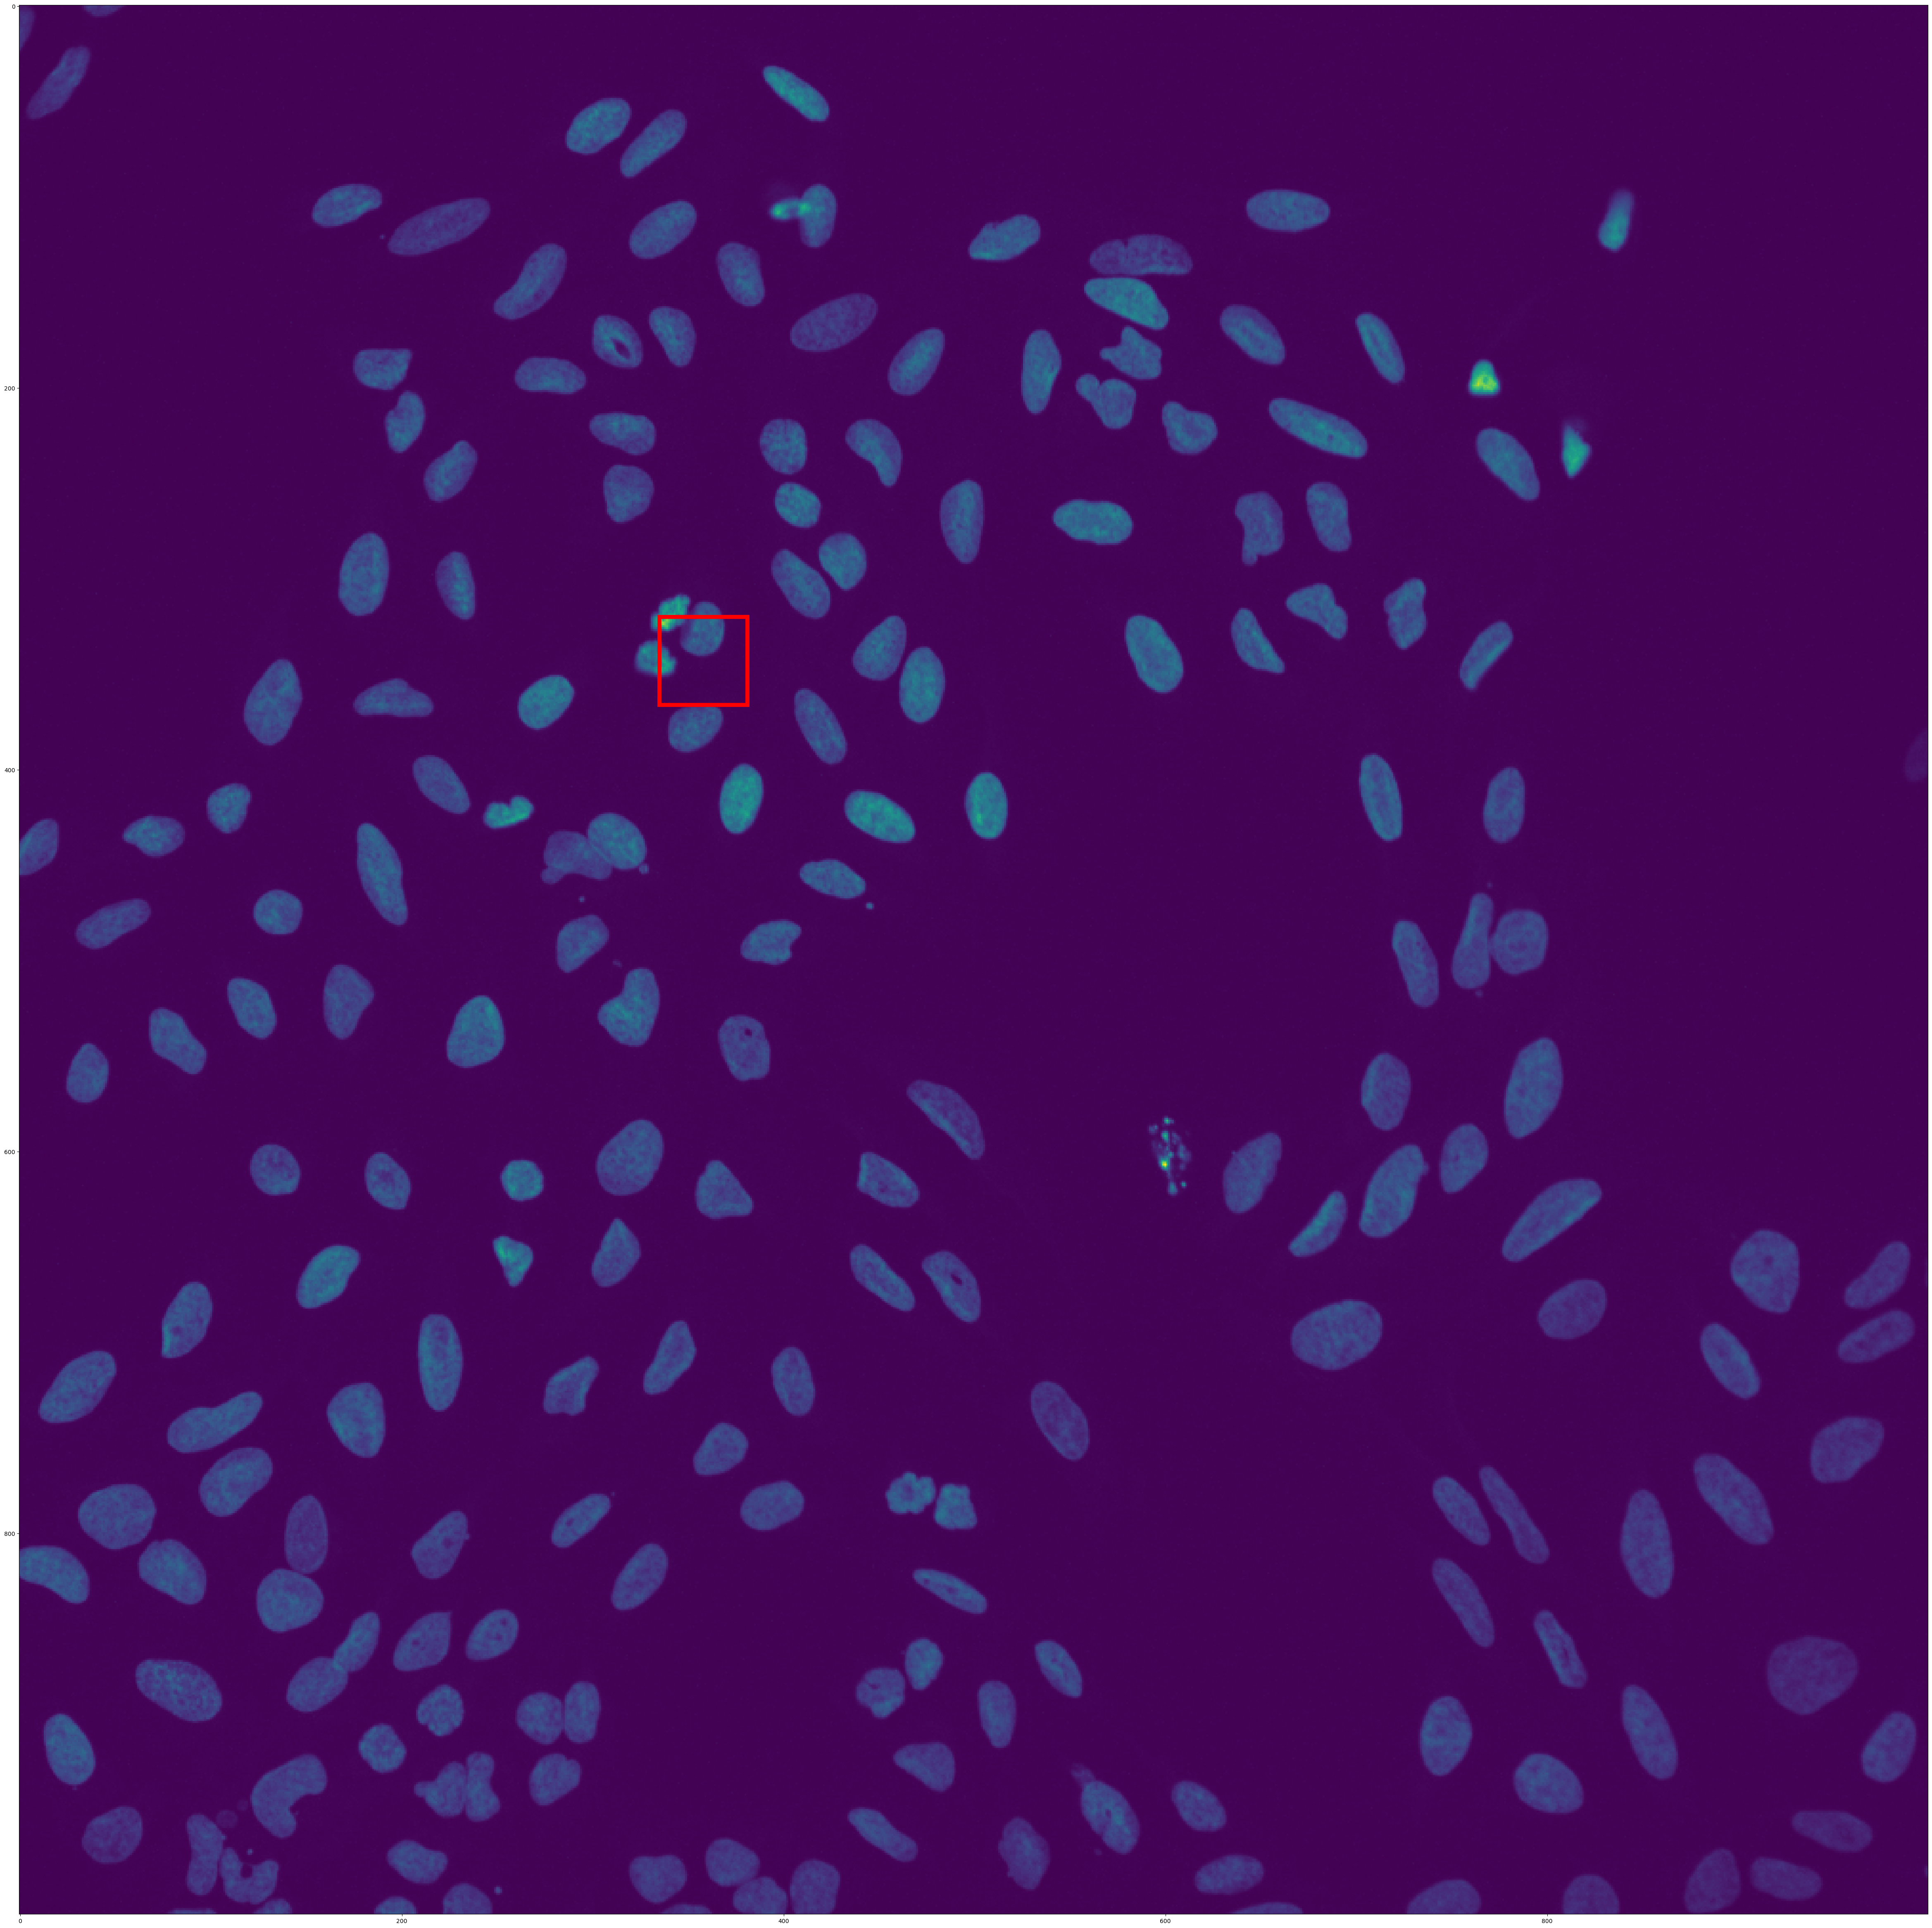

In [9]:
#Visualisation of the chosen kernel size relative to the image size
fig, axes = plt.subplots(1, 1, figsize=(60,60))
axes.imshow(features["img"][1])
rect = patches.Rectangle((335, 320), 46, 46, linewidth=7, edgecolor='r', facecolor='none')
axes.add_patch(rect)

## c) Resize images

In [10]:
shape_image = list(map(lambda x: x.shape, features["img"].to_list()))
shape_image.sort(key=lambda x:x[0])
shape_image_count = {k: shape_image.count(k) for k in set(shape_image)}
shape_image_count

{(1080, 1080): 1266,
 (1000, 1000): 654,
 (996, 996): 676,
 (998, 998): 726,
 (970, 970): 690,
 (1024, 1024): 636}

In [11]:
def crop_square_array(x, des_size):
    h, w = x.shape
    h_off, w_off = (h-des_size)//2, (w-des_size)//2
    return x[h_off:des_size+h_off,w_off:des_size+w_off]

In [12]:
image_resized = np.array(list(map(lambda x: crop_square_array(x, shape_image[0][0]), features["img"].to_list())))

In [13]:
metadata_df = metadata.to_pandas().set_index(keys="ID")
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))
labels, groups = metadata_df["moa_id"].values, metadata_df["Metadata_InChIKey"].values

## d) Split image in 4

In [14]:
image_size = image_resized.shape[1]
small_image_resized = np.vstack([image_resized[:, :image_size//2, :image_size//2], 
           image_resized[:, :image_size//2, image_size//2:],
           image_resized[:, image_size//2:, :image_size//2],
           image_resized[:, image_size//2:, image_size//2:]])
small_labels = np.hstack([labels for i in range(4)])
small_groups = np.hstack([groups for i in range(4)])

### d) Create the pytorch dataset withrespect to kfold split

### i) Custom dataset

In [15]:
class ImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None):
        super().__init__()
        self.imgs = imgs
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx): 
        return self.imgs[idx,:,:], self.img_labels[idx]

### ii) Data split

In [16]:
kfold = list(StratifiedGroupKFold_custom().split(small_image_resized, small_labels, small_groups))

In [17]:
small_image_resized_tensor = torch.unsqueeze(torch.tensor(small_image_resized, dtype=torch.float), 1)
small_labels_tensor = torch.tensor(small_labels, dtype=torch.long)
dataset_fold = {i: {"train": custom_dataset.ImageDataset(small_image_resized_tensor[kfold[i][0]], 
                                                         small_labels_tensor[kfold[i][0]]),
     "test": custom_dataset.ImageDataset(small_image_resized_tensor[kfold[i][1]], small_labels_tensor[kfold[i][1]])}
 for i in range(len(kfold))}

### iii) Memory usage per fold

In [18]:
def fold_memory_usage(fold:int, split:str ="train", batch_size:int=None):
    total_size = 0
    for i in range(len(dataset_fold[fold][split])):
        sample = dataset_fold[fold][split][i]
        sample_size = 0
        if isinstance(sample, tuple):
            for item in sample:
                if isinstance(item, torch.Tensor):
                    sample_size += item.element_size() * item.nelement()
        total_size += sample_size
    if batch_size is not None:
        normalizer = batch_size / len(dataset_fold[fold][split])
    else:
        normalizer = 1
    print(f"Total fold {fold} size for {split} set with {batch_size} "+
          f"batch_size: {normalizer * total_size / (1024 ** 2):.2f} MB")
    
fold_memory_usage(0, "train", None)

Total fold 0 size for train set with None batch_size: 12594.78 MB


# 2) Model
## a) model definition

In [19]:
class VGG(nn.Module):
    def __init__(self, img_depth, img_size, lab_dim, n_conv_block, n_conv_list, n_lin_block):
        super().__init__()
        self.img_depth = img_depth
        self.img_size = img_size
        self.img_size = img_size
        self.lab_dim = lab_dim
        self.n_conv_block = n_conv_block
        self.n_conv_list = n_conv_list
        self.n_lin_block = n_lin_block
        self.fc_dim = 12 * (2 ** (self.n_conv_block - 1)) * ((self.img_size // (2 ** self.n_conv_block)) ** 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        self.sequence = nn.Sequential(
                        *[self.conv_block((12 * (2 ** (i-1)) if i != 0 else self.img_depth),
                                          (12 * (2 ** i) if i!=0 else 12),
                                          self.n_conv_list[i])
                                     for i in range(self.n_conv_block)],
                        nn.Flatten(),
                        *[self.linear_block(self.fc_dim // (4 ** i), self.fc_dim // (4 ** (i + 1)))
                          for i in range(self.n_lin_block - 1)],
                        nn.Linear(self.fc_dim // (4 ** (self.n_lin_block - 1)), self.lab_dim))
        
    def conv_block(self, in_ch, out_ch, num_conv):
        return nn.Sequential(
            *sum([(nn.Conv2d(in_channels=(in_ch if i==0 else out_ch), out_channels=out_ch, 
                             kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(out_ch),
                   self.relu)
              for i in range(num_conv)], ()),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

    def linear_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=out_dim),
            self.relu,
            self.drop
        )

    def forward(self, x):
        return self.sequence(x)

## b) Receptive field calculation
Receptive field are important to visualise what information of the original image is convolve to get end features 
Computation of the receptive field is base don this [article](https://distill.pub/2019/computing-receptive-fields/). 

In [20]:
def compute_receptive_field(model):
    dict_module = dict(torch.fx.symbolic_trace(model).named_modules())
    def extract_kernel_stride(module):
        try:
            return (module.kernel_size[0] if type(module.kernel_size) == tuple else module.kernel_size, 
                    module.stride[0] if type(module.stride) == tuple else module.stride) 
        except:
            return None
    
    k, s = list(map(lambda x: np.array(list(x)), 
                    unzip([x for x in list(map(extract_kernel_stride, list(dict_module.values()))) if x is not None])))
    return ((k-1) * np.concatenate((np.array([1]), s.cumprod()[:-1]))).sum() + 1

def compute_receptive_field_recursive(model):
    dict_module = dict(torch.fx.symbolic_trace(model).named_modules())
    def extract_kernel_stride(module):
        try:
            return (module.kernel_size[0] if type(module.kernel_size) == tuple else module.kernel_size, 
                    module.stride[0] if type(module.stride) == tuple else module.stride) 
        except:
            return None
    
    k, s = list(map(lambda x: np.array(list(x))[::-1], 
                    unzip([x for x in list(map(extract_kernel_stride, list(dict_module.values()))) if x is not None])))

    res = [1, k[0]]
    for i in range(1, len(k)):
        res.append(s[i]*res[i]+k[i]-s[i])
    return res
    

## c) Memory usage calculation
Memory is the bottleneck in GPU training so knowing the size of the model is important

In [21]:
def model_memory_usage(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.2f}MB'.format(size_all_mb))
    free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
    print(f"Free memory in cuda 0 before model load: {free_mem / 1024**2:.2f} MB")
    free_mem = torch.cuda.get_device_properties(1).total_memory - torch.cuda.memory_allocated(1)
    print(f"Free memory in cuda 1 before model load: {free_mem / 1024**2:.2f} MB")

In [22]:
# vgg = VGG(img_depth=1, 
#           img_size=970, 
#           lab_dim=7, 
#           n_conv_block=6, 
#           n_conv_list=[2 for _ in range(6)], 
#           n_lin_block=3)

vgg = VGG(img_depth=1, 
          img_size=485, 
          lab_dim=7, 
          n_conv_block=5, 
          n_conv_list=[1 for _ in range(5)], 
          n_lin_block=3)

In [23]:
# print(f'recursive receptive field from very end to start: {compute_receptive_field_recursive(vgg)}')
print(f'recursive receptive field at the start: {compute_receptive_field(vgg)}')
model_memory_usage(vgg)

recursive receptive field at the start: 94
model size: 1891.99MB
Free memory in cuda 0 before model load: 48647.56 MB
Free memory in cuda 1 before model load: 48669.75 MB


In [24]:
dataset_fold[0]["train"][0][0][0]

tensor([[305., 295., 307.,  ..., 404., 430., 436.],
        [339., 313., 308.,  ..., 379., 385., 414.],
        [340., 329., 316.,  ..., 405., 396., 411.],
        ...,
        [444., 459., 452.,  ..., 542., 536., 498.],
        [425., 441., 440.,  ..., 554., 555., 523.],
        [428., 448., 411.,  ..., 560., 581., 564.]])

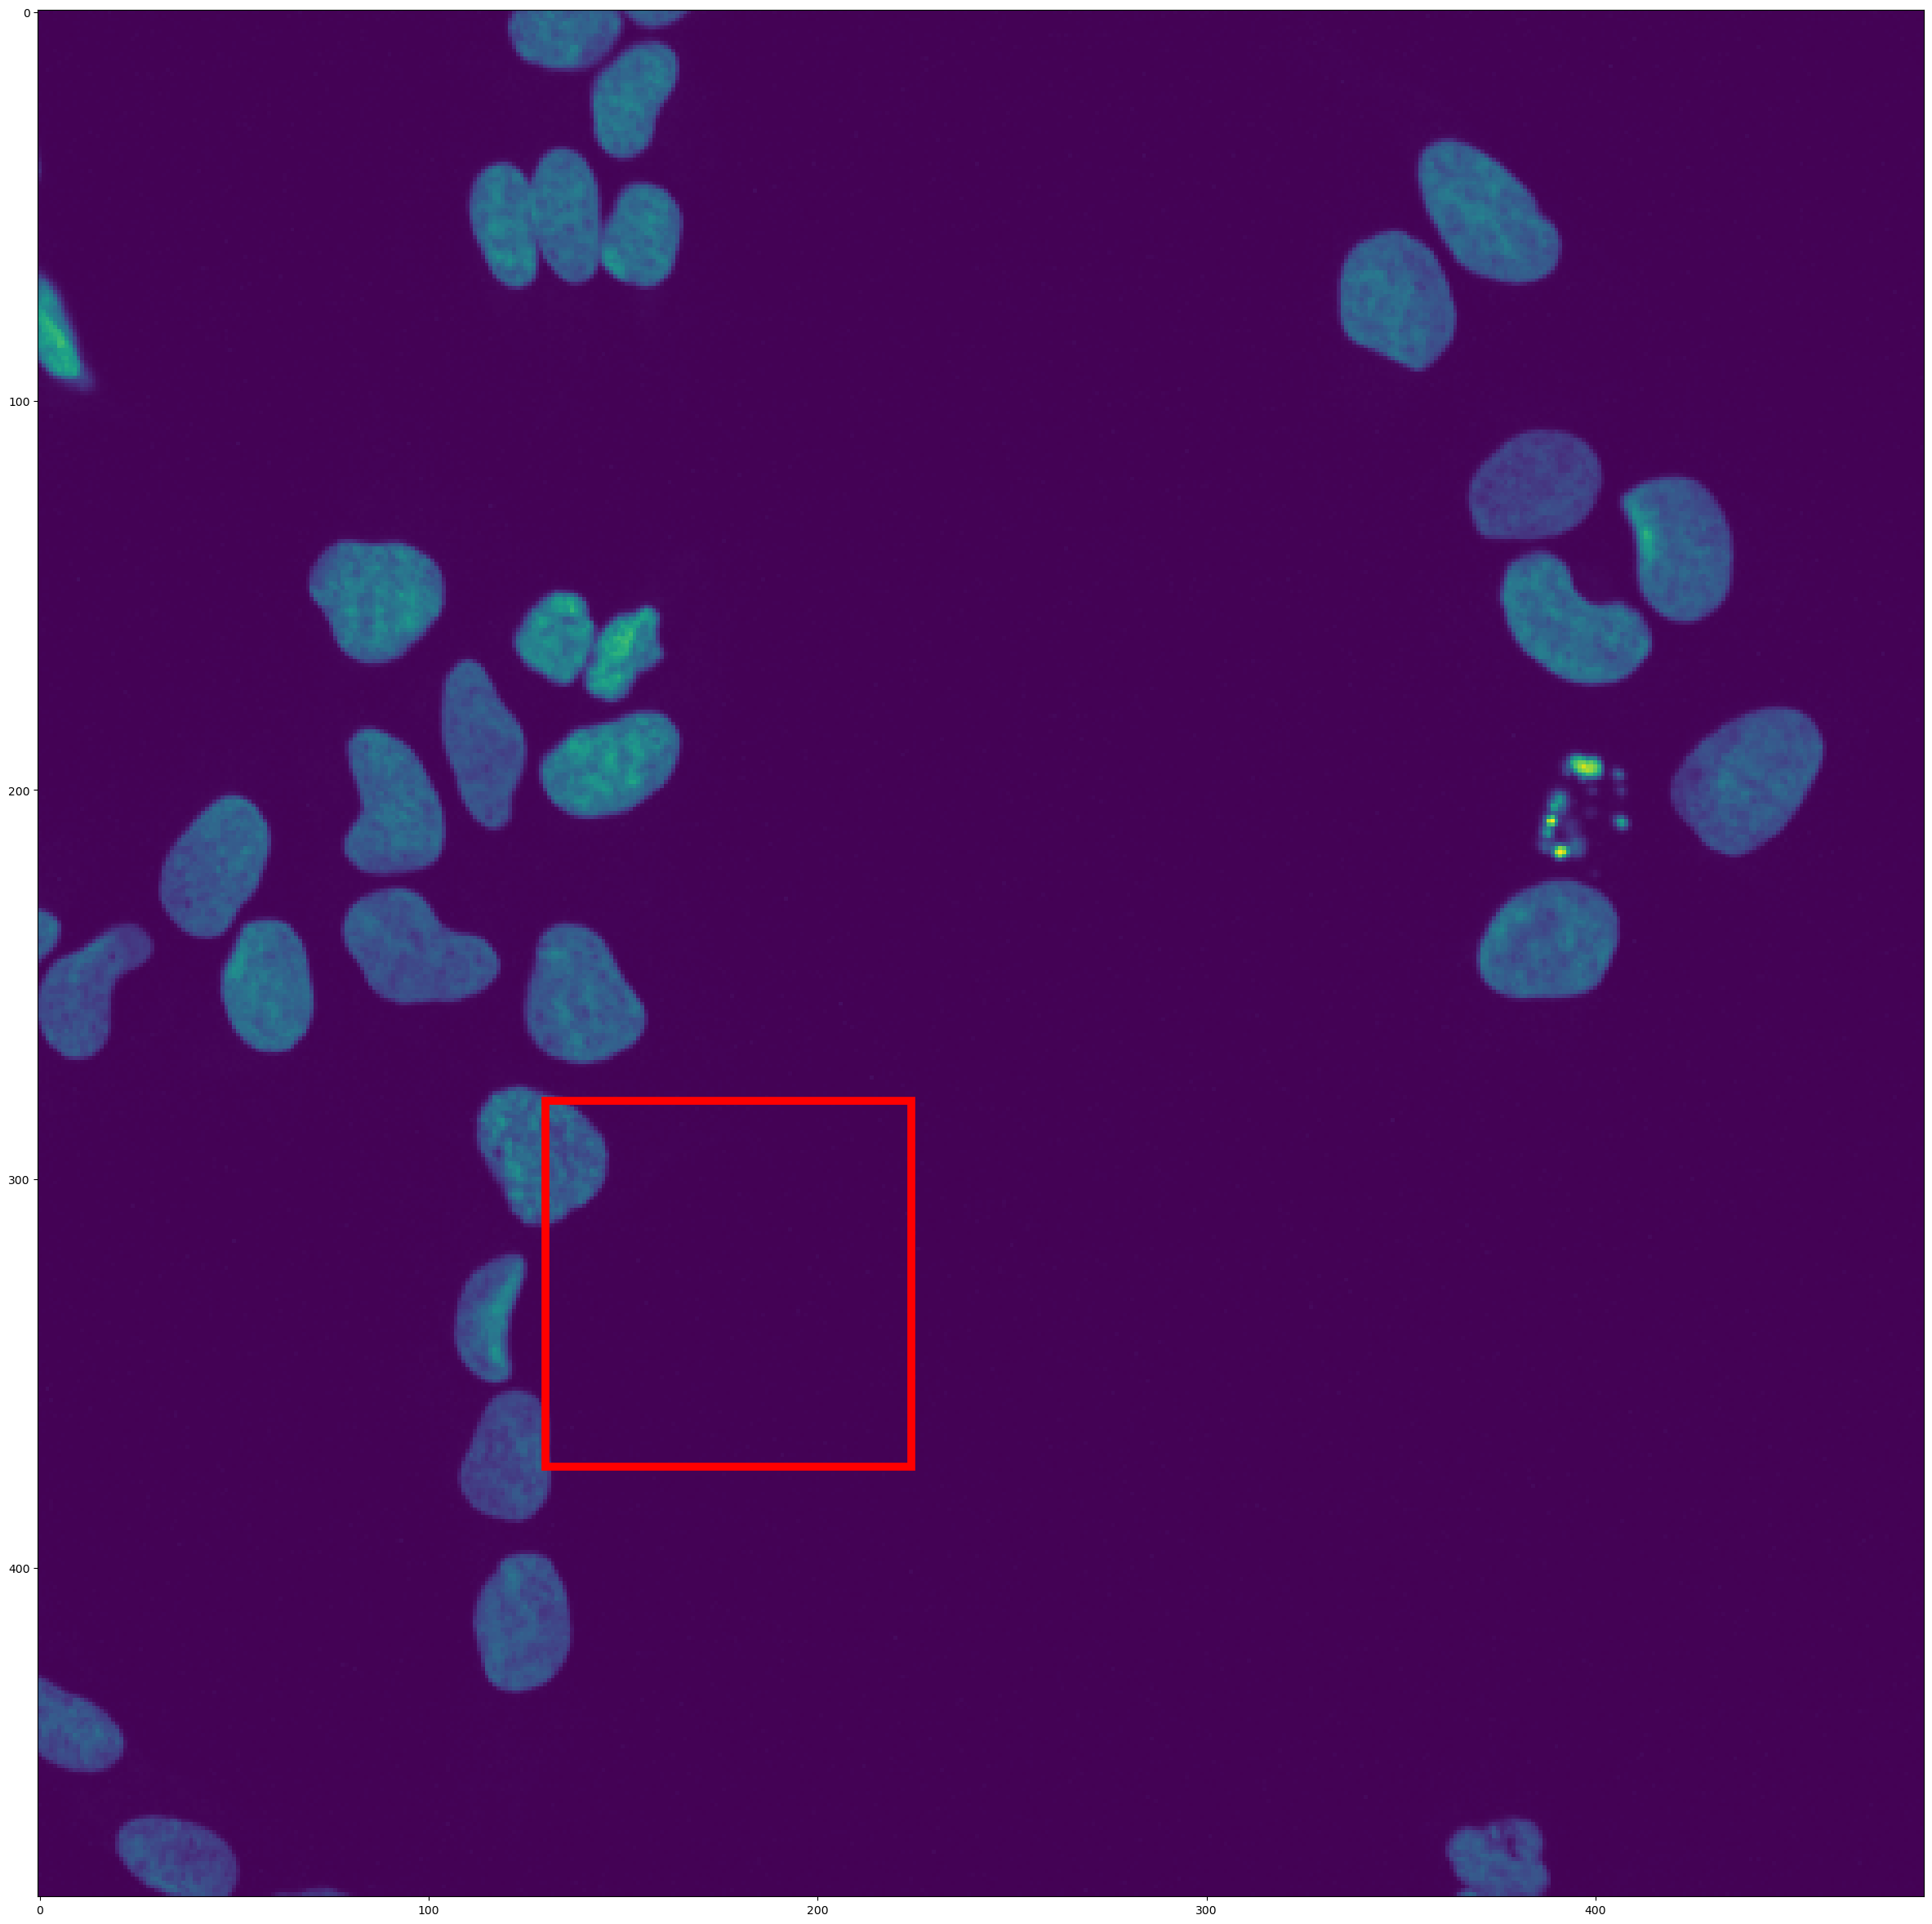

In [25]:
#Visualisation of the chosen kernel size relative to the image size
fig, axes = plt.subplots(1, 1, figsize=(30,30))
axes.imshow(dataset_fold[0]["train"][1][0][0])
rect = patches.Rectangle((130, 280), 94, 94, linewidth=7, edgecolor='r', facecolor='none')
axes.add_patch(rect)

### No need for parallel model
### Let's however speed up training by taking advantage of the 2 GPU. 

# 3) Trainer

## b) DistributedDataParallel

In [ ]:
# run_train(model=conv_model.VGG, 
#           model_param=(1, #img_depth
#                        970, #img_size
#                        7, #lab_dim
#                        6, #n_conv_block
#                        [2, 2, 2, 2, 2, 2], #n_conv_list
#                        3), #n_lin_block
#           adam_param={"lr": 1e-3,
#                       "weight_decay":0}, 
#           dataset=dataset_fold[0]["train"],
#           batch_size=16, 
#           epochs=100, 
#           fold=0,
#           filename='ddp_trained_model_fold_',
#           log_loss={})

[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
  1%|          | 1/100 [01:54<3:08:40, 114.35s/it]

In [170]:
import os 
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [172]:
torch.cuda.empty_cache()
res_df = run_train(
          model=conv_model.VGG, 
          model_param=(1, #img_depth
                       485, #img_size
                       7, #lab_dim
                       5, #n_conv_block
                       [1, 1, 1, 1, 1], #n_conv_list
                       3), #n_lin_block
          adam_param={"lr": 1e-3,
                      "weight_decay":0}, 
          train_dataset=dataset_fold[0]["train"],
          test_dataset=dataset_fold[0]["test"],
          batch_size=512, 
          epochs=3, 
          fold=0,
          filename='vgg8',
          allow_eval=True
)

[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
  0%|          | 0/3 [00:00<?, ?it/s]/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /build/source/aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
100%|██████████| 3/3 [36:57<00:00, 739.09s/it]


In [173]:
res_df = pd.read_pickle("trained_model/vgg8_fold_0_result.pkl")

In [174]:
def train_test_line_plot(train_arr, test_arr, ax, title, ylabel):
    num_epoch = len(train_arr)
    sns.lineplot(train_arr, ax=ax, label="train") 
    sns.lineplot(test_arr, ax=ax, label="test")
    ax.legend(title="split")
    ax.set_title(title)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(num_epoch), np.arange(num_epoch))
    return ax


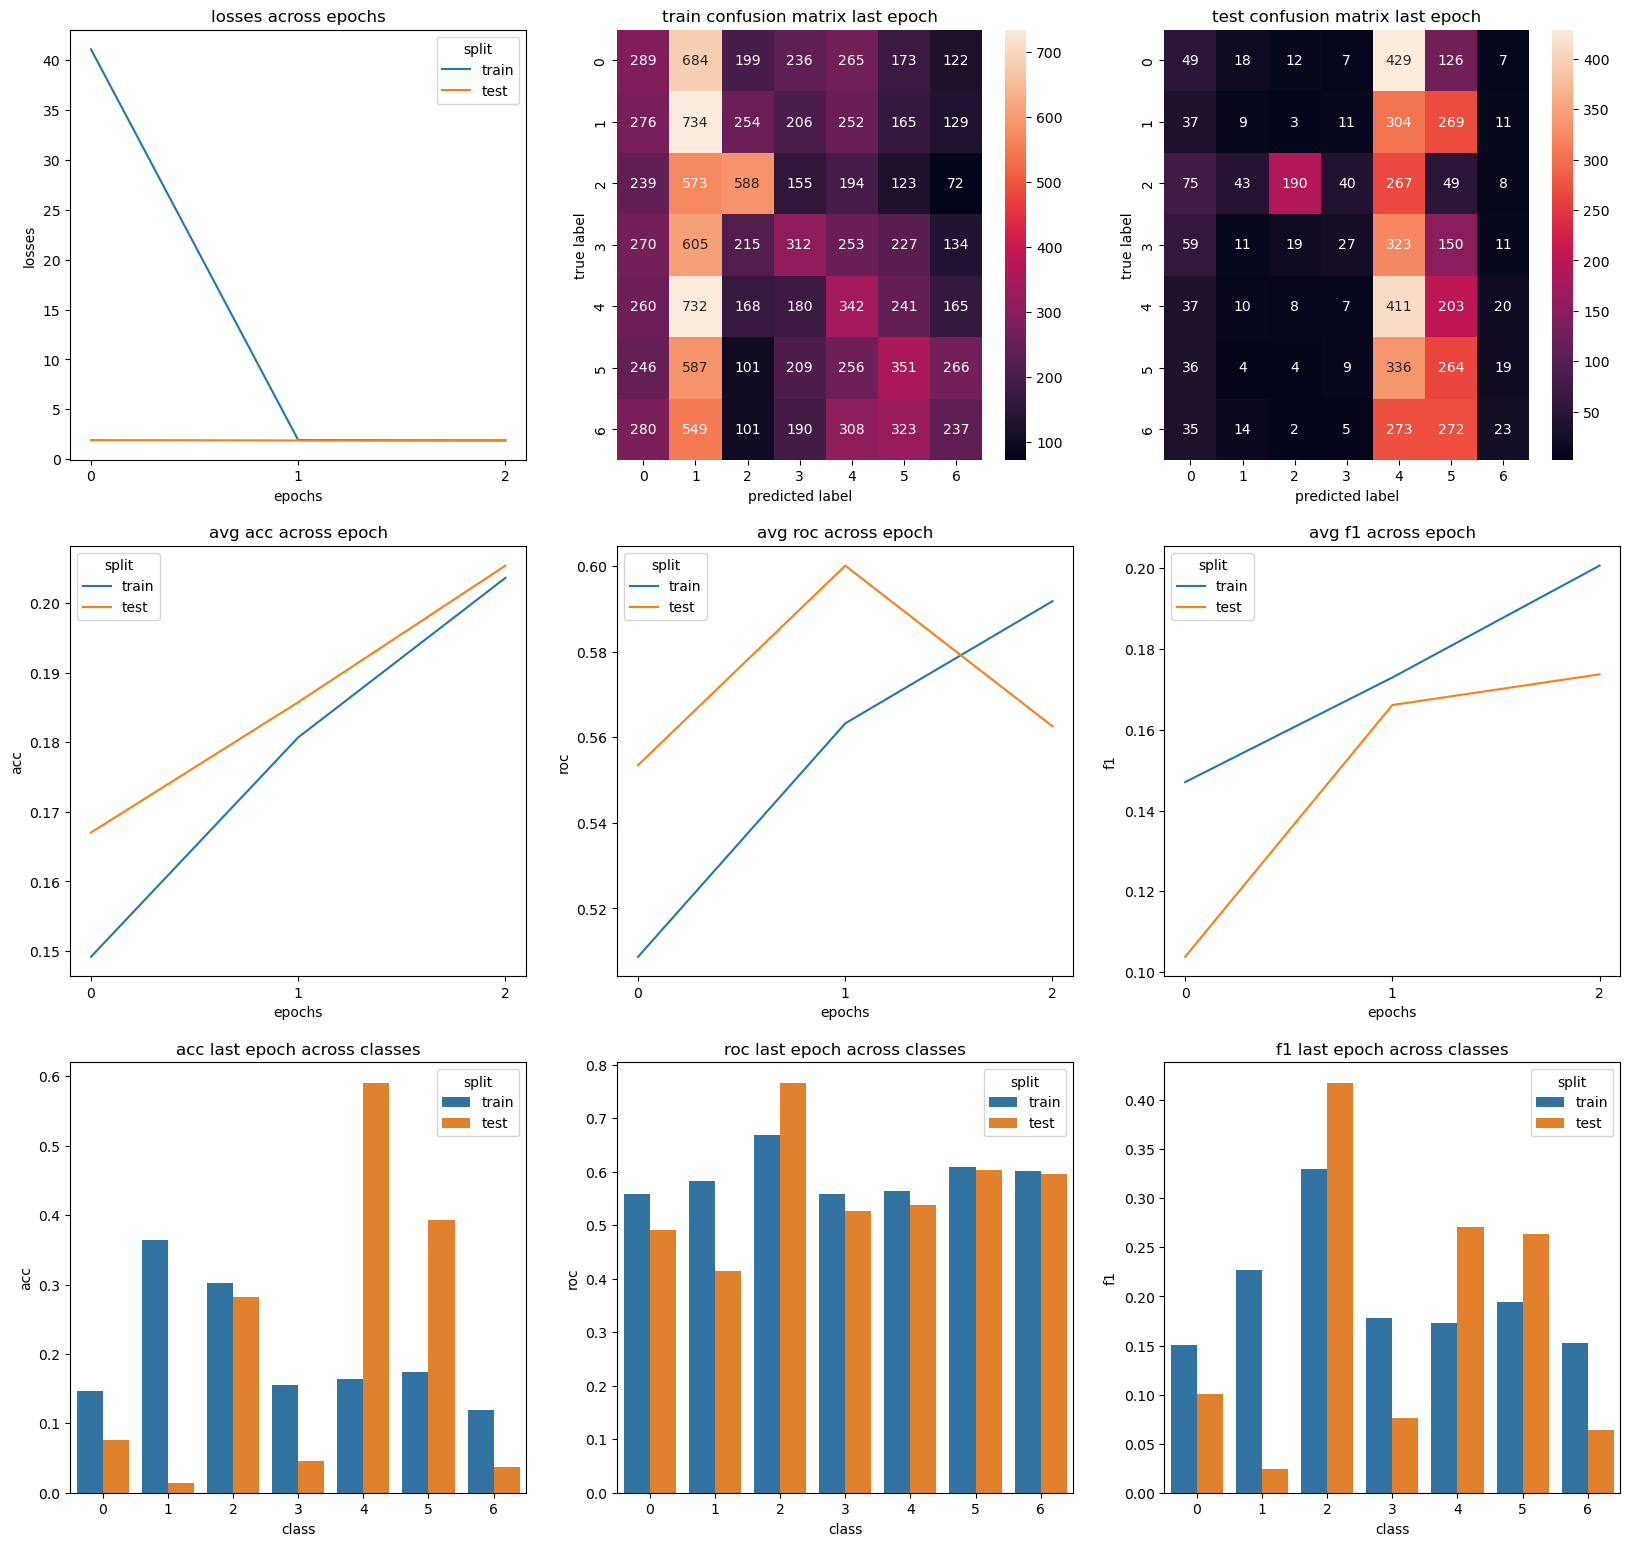

In [175]:
fig, axes = plt.subplots(3,3, figsize=(20, 19))
axes[0][0] = train_test_line_plot(res_df.loc["losses"]["train"], res_df.loc["losses"]["test"],
                     ax=axes[0][0],
                     title="losses across epochs", 
                     ylabel="losses")
for i, split in enumerate(["train", "test"]):
    sns.heatmap(res_df.loc["matrix"][split], ax=axes[0][i+1], annot=True, fmt=".0f")
    axes[0][i+1].set_xlabel("predicted label")
    axes[0][i+1].set_ylabel("true label")
    axes[0][i+1].set_title(f"{split} confusion matrix last epoch")
for i, metric_key in enumerate(["acc", "roc", "f1"]):
    metric_train, metric_test = res_df.loc[metric_key]["train"], res_df.loc[metric_key]["test"]
    axes[1][i] = train_test_line_plot(metric_train.mean(axis=1), metric_test.mean(axis=1), 
                                      ax=axes[1][i], 
                                      title=f"avg {metric_key} across epoch", 
                                      ylabel=metric_key)

    # Combine train and test last epoch data into a DataFrame
    num_class = metric_train.shape[1]
    df = pd.DataFrame({
        'class': list(range(num_class)) + list(range(num_class)),
        metric_key: list(metric_train[-1, :]) + list(metric_test[-1, :]),
        'split': ["train"] * num_class + ["test"] * num_class
    })
    
    # Create the barplot
    sns.barplot(x='class', y=metric_key, hue='split', data=df, ax=axes[2][i])
    axes[2][i].set_title(f"{metric_key} last epoch across classes")
# Display the plot
plt.show()

# Lightning Training

In [28]:
seed_everything(42, workers=True)
lit_model = LightningModel(conv_model.VGG, 
                           model_param=(1, #img_depth
                                        485, #img_size
                                        7, #lab_dim
                                        5, #n_conv_block
                                        [1, 1, 1, 1, 1], #n_conv_list
                                        3), 
                           lr=1e-3, 
                           weight_decay=0, 
                           max_epoch=1, 
                           n_class=7)

trainer = L.Trainer(default_root_dir="./lightning_checkpoint_log/", 
                    deterministic=True,
                    accelerator="gpu",
                    devices=2,
                    strategy="ddp",
                    max_epochs=1
                    )

Seed set to 42


MisconfigurationException: `Trainer(strategy='ddp')` is not compatible with an interactive environment. Run your code as a script, or choose a notebook-compatible strategy: `Trainer(strategy='ddp_notebook')`. In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

In [27]:
trainer.fit(lit_model,dataset_fold[0]["train"], dataset_fold[0]["test"])

RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.